In [6]:
import pickle
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [7]:
# Load the data
with open('masked_train_features.pkl', 'rb') as f:
    data = pickle.load(f)

features = data['features']
labels = data['labels']

print(f"Original features shape: {features.shape}")
print(f"Labels shape: {labels.shape}")

# Flatten the (197, 768) feature maps into 1D vectors
# Shape: (n_samples, 197, 768) -> (n_samples, 151296)
n_samples = features.shape[0]
features_flattened = features.reshape(n_samples, -1)

print(f"Flattened features shape: {features_flattened.shape}")


Original features shape: (1471, 197, 768)
Labels shape: (1471,)
Flattened features shape: (1471, 151296)


In [8]:
# Standardize the features (important for PCA)
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features_flattened)

# Apply PCA
n_components = 50  # You can adjust this
pca = PCA(n_components=n_components)
features_pca = pca.fit_transform(features_scaled)

print(f"\nPCA-transformed shape: {features_pca.shape}")
print(f"Explained variance ratio (first 10 components): {pca.explained_variance_ratio_[:10]}")
print(f"Total variance explained by {n_components} components: {pca.explained_variance_ratio_.sum():.4f}")

# Find how many components needed for 95% variance
cumsum_var = np.cumsum(pca.explained_variance_ratio_)
n_components_95 = np.argmax(cumsum_var >= 0.95) + 1
print(f"Number of components needed for 95% variance: {n_components_95}")



PCA-transformed shape: (1471, 50)
Explained variance ratio (first 10 components): [0.03963783 0.02359633 0.01713979 0.01003097 0.00813908 0.00670399
 0.00612371 0.00522546 0.00450965 0.00389106]
Total variance explained by 50 components: 0.2005
Number of components needed for 95% variance: 1


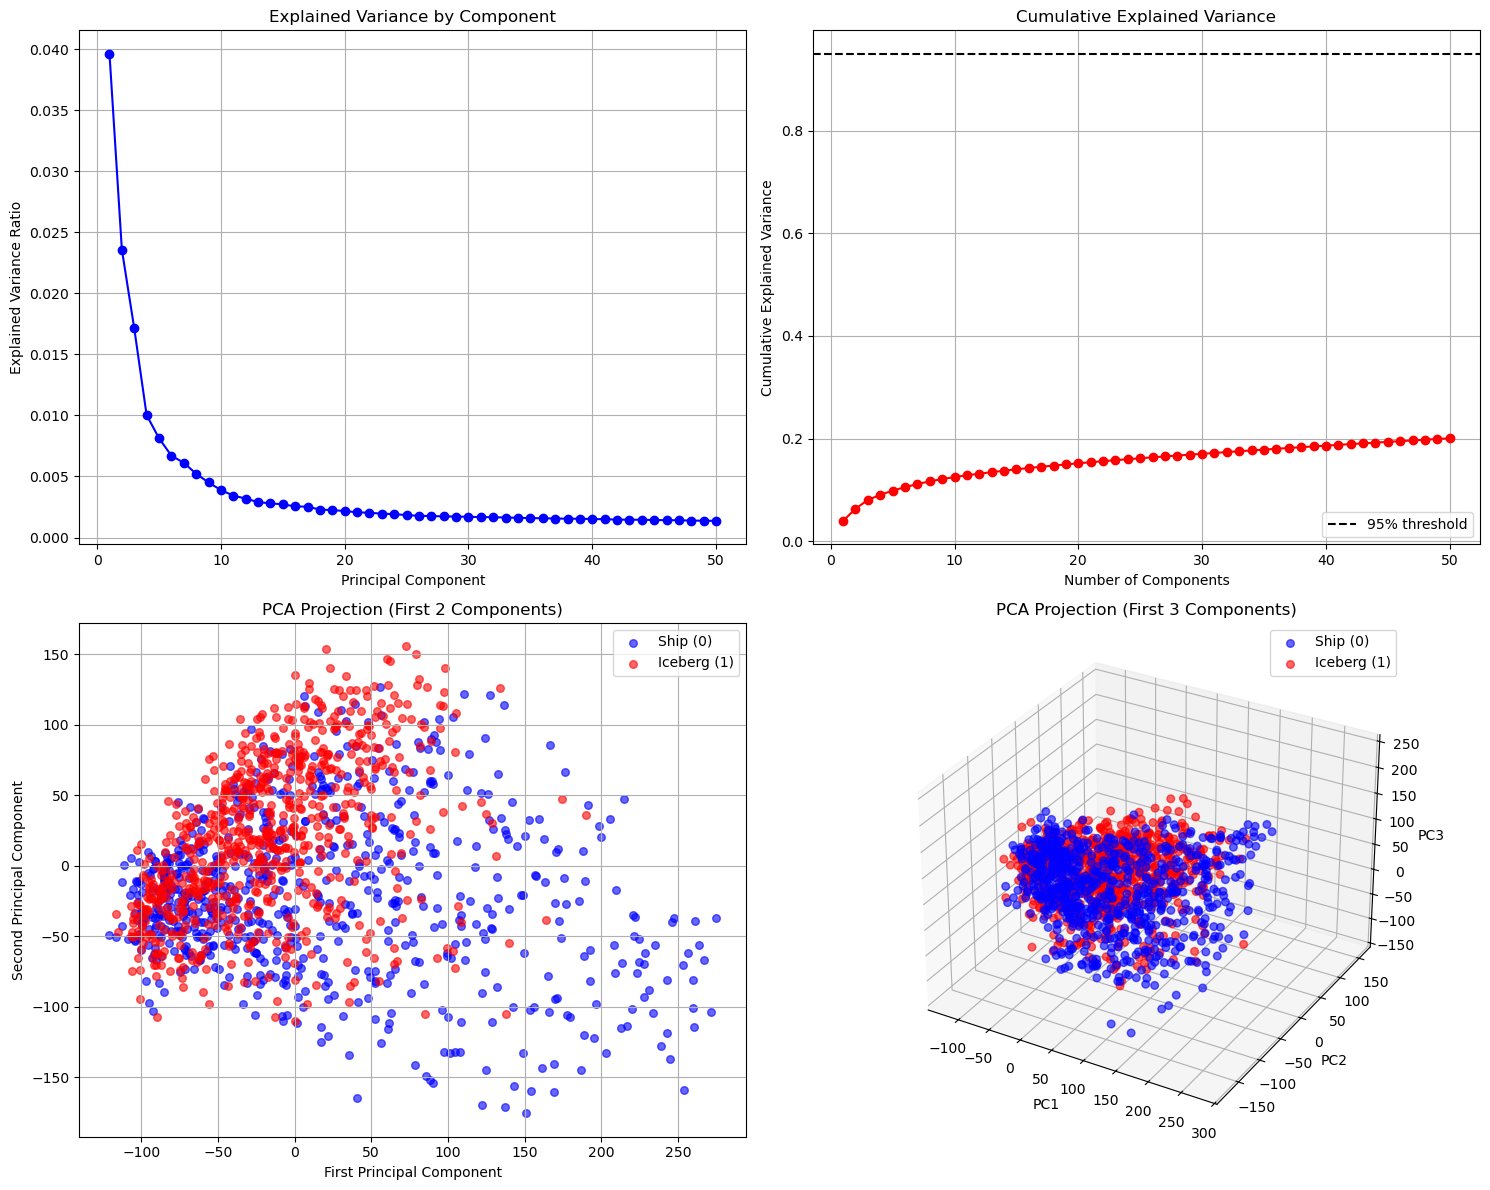


PCA features saved to 'features_pca.npy'


In [12]:
# Visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: Explained variance per component
axes[0, 0].plot(range(1, n_components+1), pca.explained_variance_ratio_, 'bo-')
axes[0, 0].set_xlabel('Principal Component')
axes[0, 0].set_ylabel('Explained Variance Ratio')
axes[0, 0].set_title('Explained Variance by Component')
axes[0, 0].grid(True)

# Plot 2: Cumulative explained variance
axes[0, 1].plot(range(1, n_components+1), cumsum_var, 'ro-')
axes[0, 1].set_xlabel('Number of Components')
axes[0, 1].set_ylabel('Cumulative Explained Variance')
axes[0, 1].set_title('Cumulative Explained Variance')
axes[0, 1].grid(True)
axes[0, 1].axhline(y=0.95, color='k', linestyle='--', label='95% threshold')
axes[0, 1].legend()

# Plot 3: First two principal components colored by class
axes[1, 0].scatter(features_pca[labels==0, 0], features_pca[labels==0, 1], 
                   c='blue', label='Ship (0)', alpha=0.6, s=30)
axes[1, 0].scatter(features_pca[labels==1, 0], features_pca[labels==1, 1], 
                   c='red', label='Iceberg (1)', alpha=0.6, s=30)
axes[1, 0].set_xlabel('First Principal Component')
axes[1, 0].set_ylabel('Second Principal Component')
axes[1, 0].set_title('PCA Projection (First 2 Components)')
axes[1, 0].legend()
axes[1, 0].grid(True)

# Plot 4: First three principal components in 3D
from mpl_toolkits.mplot3d import Axes3D
axes[1, 1].remove()
ax_3d = fig.add_subplot(2, 2, 4, projection='3d')
ax_3d.scatter(features_pca[labels==0, 0], features_pca[labels==0, 1], features_pca[labels==0, 2],
              c='blue', label='Ship (0)', alpha=0.6, s=30)
ax_3d.scatter(features_pca[labels==1, 0], features_pca[labels==1, 1], features_pca[labels==1, 2],
              c='red', label='Iceberg (1)', alpha=0.6, s=30)
ax_3d.set_xlabel('PC1')
ax_3d.set_ylabel('PC2')
ax_3d.set_zlabel('PC3')
ax_3d.set_title('PCA Projection (First 3 Components)')
ax_3d.legend()

plt.tight_layout()
plt.show()


# Save the PCA-transformed features
np.save('features_pca.npy', features_pca)
print(f"\nPCA features saved to 'features_pca.npy'")



PCA features saved to 'features_pca.npy'


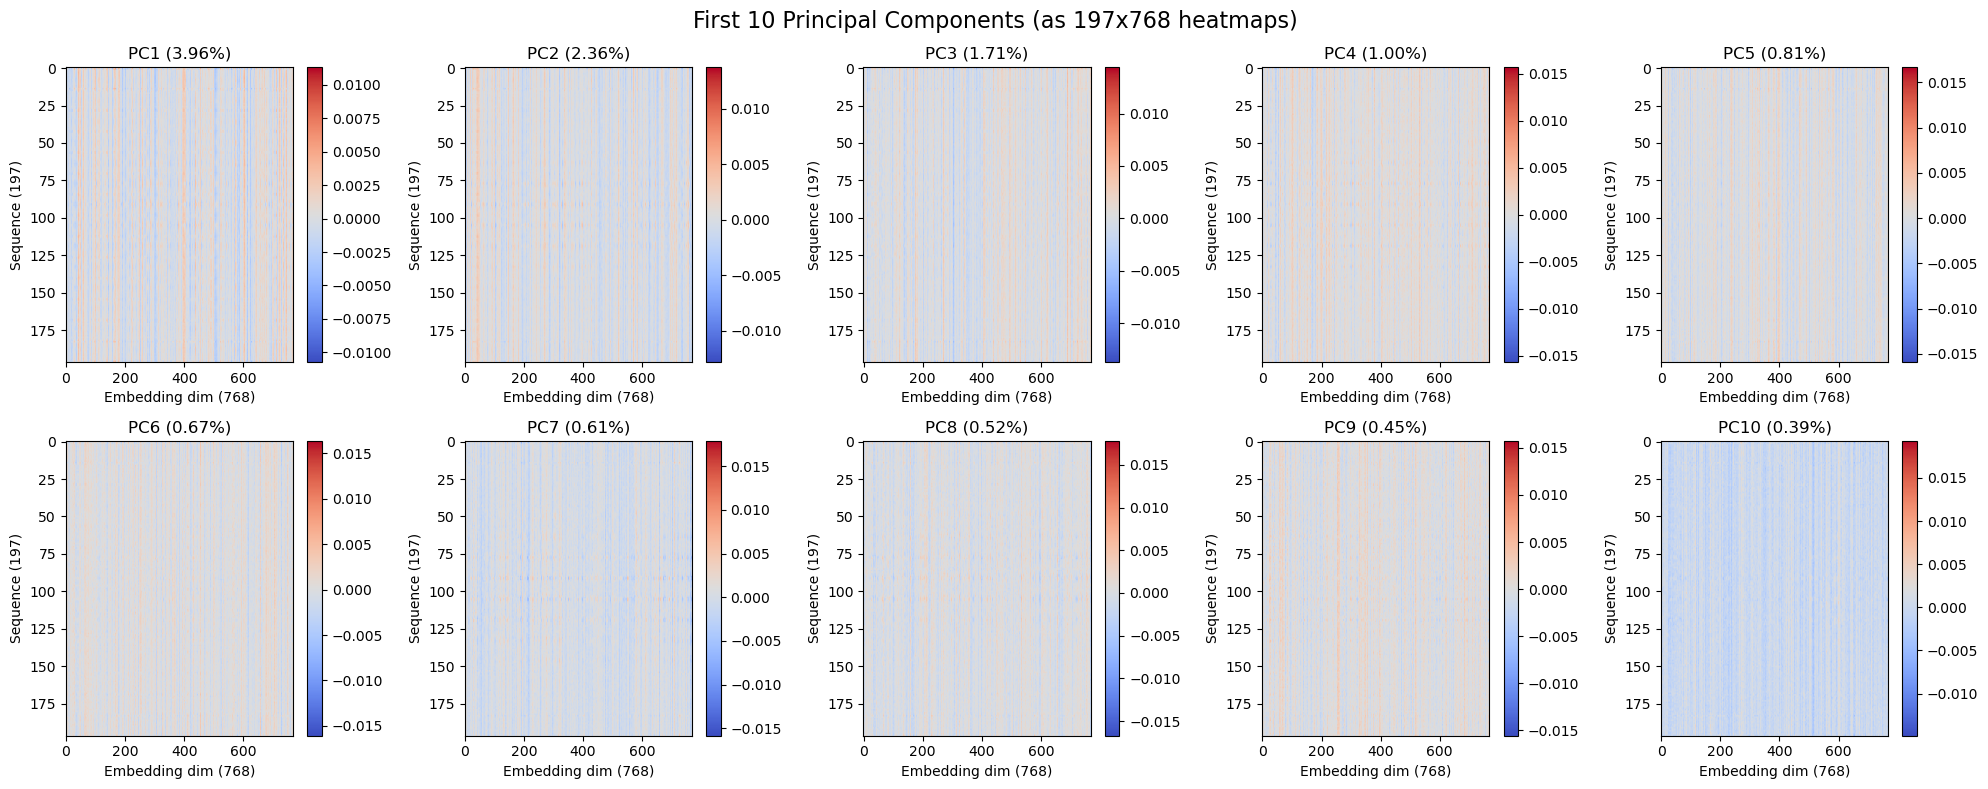

In [10]:
# Visualize the principal components as (197, 768) heatmaps
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
for i in range(10):
    ax = axes[i // 5, i % 5]
    # Reshape the component back to (197, 768) to visualize
    component_image = pca.components_[i].reshape(197, 768)
    im = ax.imshow(component_image, cmap='coolwarm', aspect='auto')
    ax.set_title(f'PC{i+1} ({pca.explained_variance_ratio_[i]*100:.2f}%)')
    ax.set_xlabel('Embedding dim (768)')
    ax.set_ylabel('Sequence (197)')
    plt.colorbar(im, ax=ax)
plt.suptitle('First 10 Principal Components (as 197x768 heatmaps)', fontsize=16)
plt.tight_layout()
plt.show()

In [13]:
import pandas as pd

# Create DataFrame with PCA features
columns = [f'PC{i+1}' for i in range(50)]  # PC1, PC2, ..., PC50
df_pca = pd.DataFrame(features_pca, columns=columns)

# Add labels as the last column
df_pca['label'] = labels

# Save to CSV
df_pca.to_csv('pca_features_50.csv', index=False)
print("Saved to 'pca_features_50.csv'")


Saved to 'pca_features_50.csv'
